https://docs.opencv.org/4.5.0/d3/dc0/group__imgproc__shape.html

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import cv2
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np

from VPU import OpenVINOHandler
from craterdetection.deepmoon import template_match_t

exp = OpenVINOHandler('DeepMoon', device='CPU', root='../VPU/IR/')

sd_input_images = np.load('../blobs/sd_input_images.npy').transpose(0, 3, 1, 2)
sd_target_masks = np.load('../blobs/sd_target_masks.npy')
exp

OpenVINOHandler(device=CPU, input_layout=NCHW, input_shape=(1, 1, 256, 256))

In [3]:
%%time
batch = sd_input_images[0:10]
targets = sd_target_masks[0:10]
out = exp.infer(batch)

C:\Users\w_dop\miniconda3\envs\openvino\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Wall time: 25 s


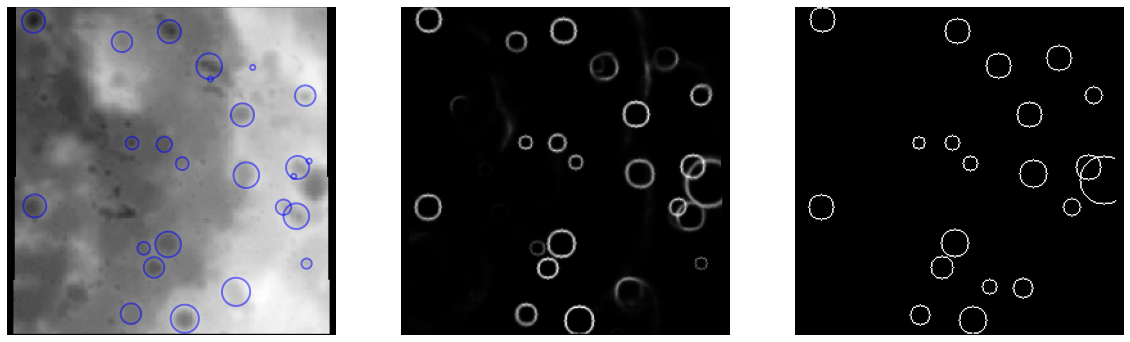

In [193]:
i = 3

extracted_rings = template_match_t(out[i, 0].copy(), minrad=2.5)

fig, axes = plt.subplots(1, 3, figsize=(20, 10))
axes[0].imshow(batch[i, 0], cmap='Greys_r')
axes[0].axis('off')
axes[1].imshow(out[i, 0], cmap='Greys_r')
axes[1].axis('off')
axes[2].imshow(targets[i], cmap='Greys_r')
axes[2].axis('off')

for x, y, r in extracted_rings:
    circle = plt.Circle((x, y), r, color='blue', fill=False, linewidth=2, alpha=0.5)
    axes[0].add_artist(circle)

In [ ]:
i = 2

imgray = np.uint8(out[i, 0]*255)
ret, thresh = cv2.threshold(imgray, 10, 255, 0)
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = [cnt for cnt in contours if (len(cnt) >= 10 and len(cnt) < 120)]

convex_hulls = [
    cv2.convexHull(cnt) for cnt in contours
]

ellipses = [
    cv2.fitEllipse(cnt) for cnt in convex_hulls if len(cnt) >= 5
]

img_ellipses = np.zeros_like(imgray)
for e in ellipses:
    center_coordinates = (round(e[0][0]), round(e[0][1]))
    
    a = e[1][0]/2
    b = e[1][1]/2
    ellipticity = (a-b)/a if a >= b else (b-a)/b
    
    if ellipticity <= 0.1:
        axesLength = (round(a), round(b))

        angle = round(e[2])
        color = (255, 255, 255) 
        thickness = 1

        # Using cv2.ellipse() method 
        img_ellipses = cv2.ellipse(img_ellipses, center_coordinates, axesLength, 
                   angle, startAngle, endAngle, color, thickness)


fig, axes = plt.subplots(1, 3, figsize=(20, 15))


axes[0].imshow(batch[i, 0], cmap='Greys_r')
axes[0].axis('off')
axes[1].imshow(out[i, 0], cmap='Greys_r')
axes[1].axis('off')
axes[2].imshow(255*batch[i, 0]+img_ellipses, cmap='Greys_r')
axes[2].axis('off')

fig.savefig('')

In [ ]:
# cv2.MORPH_RECT
# cv2.MORPH_CROSS
# cv2.MORPH_ELLIPSE
i = 2

erosion_size = 0
max_elem = 2
max_kernel_size = 21

def erosion(src, erosion_type, erosion_size):
    element = cv2.getStructuringElement(erosion_type, (2*erosion_size + 1, 2*erosion_size+1), (erosion_size, erosion_size))
    erosion_dst = cv2.erode(src, element)
    return erosion_dst
    
def dilatation(src, dilatation_type, dilatation_size):
    element = cv2.getStructuringElement(dilatation_type, (2*dilatation_size + 1, 2*dilatation_size+1), (dilatation_size, dilatation_size))
    dilatation_dst = cv2.dilate(src, element)
    return dilatation_dst

src = out[i, 0].copy()

fig, axes = plt.subplots(1,2, figsize=(25, 10))

ret, src = cv2.threshold(src, 0.1, 1, cv2.THRESH_BINARY)

axes[0].imshow(src, cmap='Greys_r')
axes[0].axis('off')

n = 4
kernel = np.ones((n,n),np.uint8)
src = cv2.morphologyEx(src, cv2.MORPH_GRADIENT, kernel)
src = erosion(src, cv2.MORPH_ELLIPSE, 2)
axes[1].imshow(src, cmap='Greys_r')
axes[1].axis('off')


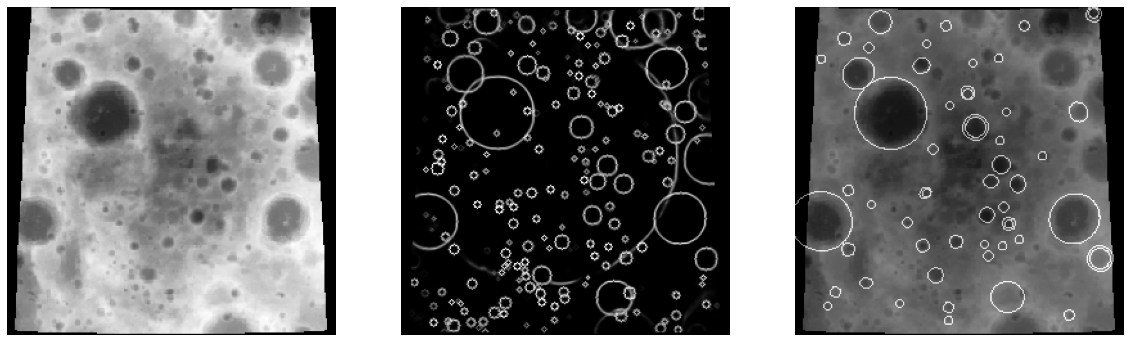

In [209]:
src = out[i, 0].copy()
ret, src = cv2.threshold(src, 0.2, 1, cv2.THRESH_BINARY)
contours, hierarchy = cv2.findContours(np.uint8(src), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
plt.imshow(cv2.drawContours(src, contours, -1, (0,255,0), 3), cmap='Greys_r')

(-0.5, 255.5, 255.5, -0.5)

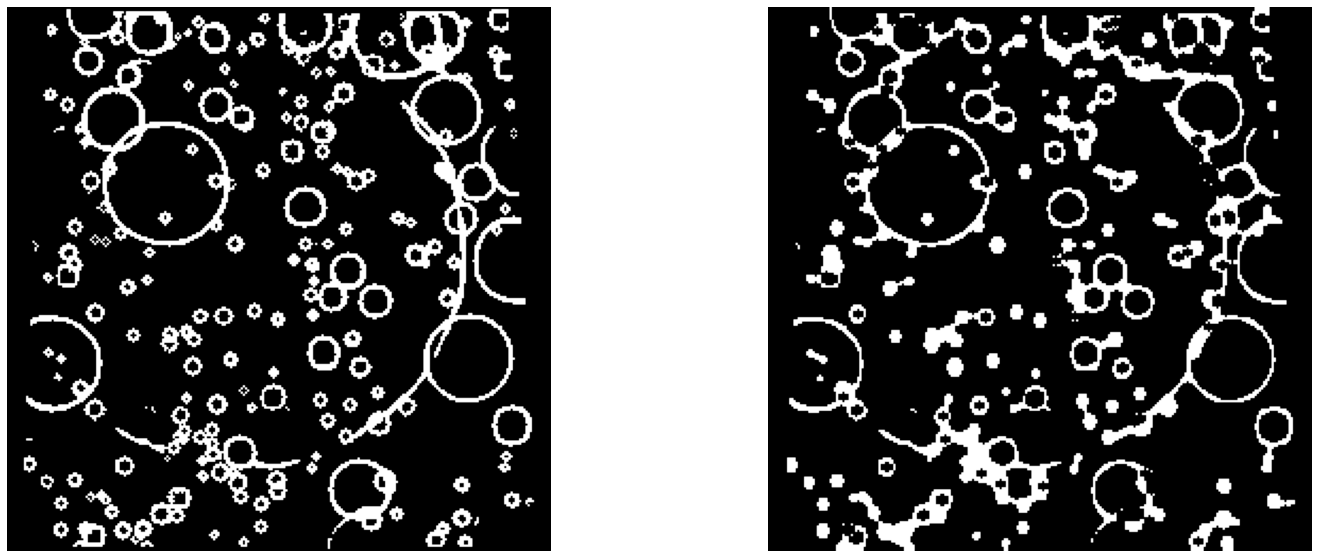

In [170]:
# cv2.MORPH_RECT
# cv2.MORPH_CROSS
# cv2.MORPH_ELLIPSE
i = 2

erosion_size = 0
max_elem = 2
max_kernel_size = 21

def erosion(src, erosion_type, erosion_size):
    element = cv2.getStructuringElement(erosion_type, (2*erosion_size + 1, 2*erosion_size+1), (erosion_size, erosion_size))
    erosion_dst = cv2.erode(src, element)
    return erosion_dst
    
def dilatation(src, dilatation_type, dilatation_size):
    element = cv2.getStructuringElement(dilatation_type, (2*dilatation_size + 1, 2*dilatation_size+1), (dilatation_size, dilatation_size))
    dilatation_dst = cv2.dilate(src, element)
    return dilatation_dst

src = out[i, 0].copy()

fig, axes = plt.subplots(1,2, figsize=(25, 10))

ret, src = cv2.threshold(src, 0.1, 1, cv2.THRESH_BINARY)

axes[0].imshow(src, cmap='Greys_r')
axes[0].axis('off')

n = 4
kernel = np.ones((n,n),np.uint8)
src = cv2.morphologyEx(src, cv2.MORPH_GRADIENT, kernel)
src = erosion(src, cv2.MORPH_ELLIPSE, 2)
axes[1].imshow(src, cmap='Greys_r')
axes[1].axis('off')


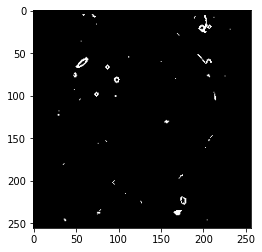

In [5]:
src = out[i, 0].copy()
ret, src = cv2.threshold(src, 0.2, 1, cv2.THRESH_BINARY)
contours, hierarchy = cv2.findContours(np.uint8(src), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
plt.imshow(cv2.drawContours(src, contours, -1, (0,255,0), 3), cmap='Greys_r')

20058.0
CPU times: user 81.8 ms, sys: 10.5 ms, total: 92.3 ms
Wall time: 78.3 ms


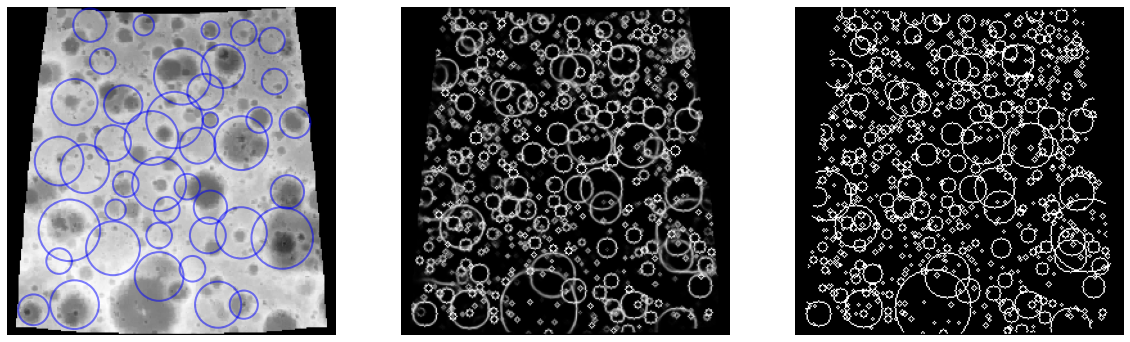

In [218]:
%%time

i = 5

fig, axes = plt.subplots(1, 3, figsize=(20, 10))
axes[0].imshow(batch[i, 0], cmap='Greys_r')
axes[0].axis('off')
axes[1].imshow(out[i, 0], cmap='Greys_r')
axes[1].axis('off')
axes[2].imshow(targets[i], cmap='Greys_r')
axes[2].axis('off')

src = out[i, 0].copy()
ret, src = cv2.threshold(src, 0.1, 1, cv2.THRESH_BINARY)
output = src.copy()*255
canvas = np.zeros_like(src)

# Find circles
print(src.sum())
circles = cv2.HoughCircles(np.uint8(src*255), cv2.HOUGH_GRADIENT, 1, 20, None, 300, 20, 5, 25)

# If some circle is found
if circles is not None:
    # Get the (x, y, r) as integers
    circles = np.round(circles[0, :]).astype("int")
    
    # loop over the circles
    for x, y, r in circles:
        circle = plt.Circle((x, y), r, color='blue', fill=False, linewidth=2, alpha=0.5)
        axes[0].add_artist(circle)
else:
    print("No circles found!")

In [219]:
from torchvision.models.detection.rpn import AnchorGenerator

/usr/local/Caskroom/miniconda/base/envs/openvino/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [252]:
anchor_generator = AnchorGenerator(
    sizes=tuple(range(5, 21)),
    aspect_ratios=(1.0,)
)

/usr/local/Caskroom/miniconda/base/envs/openvino/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# SpaceEngine test

In [18]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Image metadata
img = cv2.imread('../data/scr00005.jpg', cv2.IMREAD_GRAYSCALE)
lat, long = (-78.40696667, -42.517858) #scr00003
h = 86.52 #km
fov = 45 #degrees (vertical FOV uncropped image)

# Crop center of screenshot to input shape 
ysize, xsize = img.shape
_, _, x_in, y_in = exp.input_shape
img = img[(ysize//2)-(y_in//2):(ysize//2)+(y_in//2), (xsize//2)-(x_in//2):(xsize//2)+(x_in//2)]

# Image dimension
d = 2*(y_in/ysize)*h*np.tan(np.deg2rad(fov/2)) 
fov_crop = np.rad2deg(np.arctan(d/h))

11.109694034482995

In [ ]:
# Perform inference
batch = transforms.ToTensor()(img).unsqueeze_(0)
out = exp.infer(batch)

# Plot 
i = 0
extracted_rings = template_match_t(out[i, 0].copy(), minrad=2.5, maxrad=35)

fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(batch[i, 0], cmap='Greys_r')
axes[0].axis('off')
axes[1].imshow(out[i, 0], cmap='Greys_r')
axes[1].axis('off')

for x, y, r in extracted_rings:
    circle = plt.Circle((x, y), r, color='blue', fill=False, linewidth=2, alpha=0.5)
    axes[0].add_artist(circle)

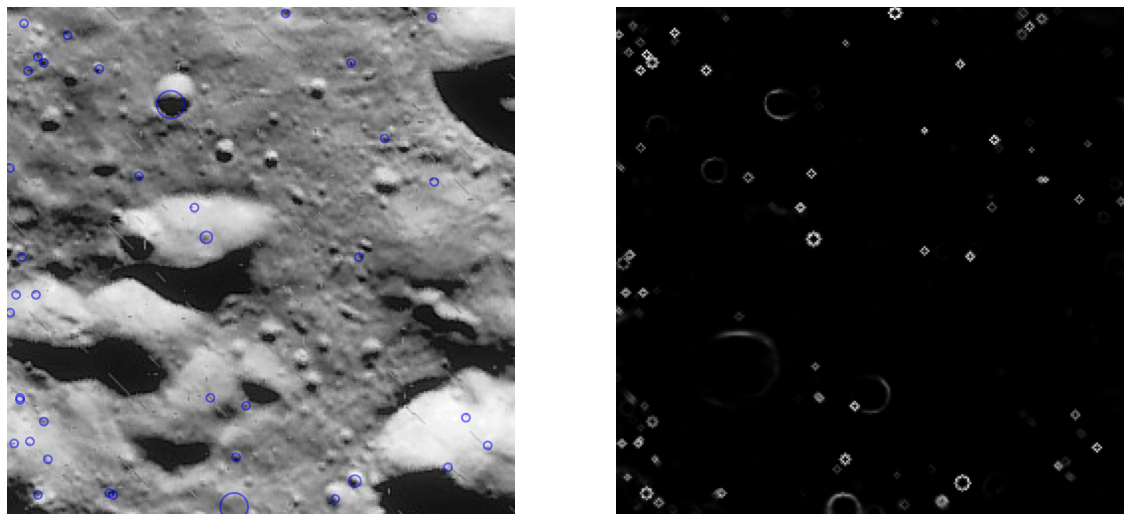

In [14]:
import pandas as pd
df_craters = pd.read_csv("../data/LU1319381_HKPolyU.txt", header=13, sep='\t')
df_craters.columns = [
    "ID", "Longitude", "Latitude", "Diameter", 
    "Depth", "Source", "Source_long", "Source_lat", "Source_dia"
]

In [44]:
import pandas as pd
df_craters = pd.read_csv("../data/LU1319381_HKPolyU.txt", header=13, sep='\t')
df_craters.columns = [
    "ID", "Longitude", "Latitude", "Diameter", 
    "Depth", "Source", "Source_long", "Source_lat", "Source_dia"
]

In [54]:
margin = 0.5

df_close = df_craters.query("(Longitude < @long + @margin) & (Longitude > @long - @margin)")
df_close = df_close.query("(Latitude < @lat + @margin) & (Latitude > @lat - @margin)")
df_close

C:\Users\w_dop\miniconda3\envs\openvino\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,ID,Longitude,Latitude,Diameter,Depth,Source,Source_long,Source_lat,Source_dia
457289,457290,-42.9616,-78.7933,2836.4,223.5,0,0.0,0.0,0.0
457415,457416,-42.9153,-78.8408,2388.2,269.6,0,0.0,0.0,0.0
457518,457519,-42.8744,-78.7082,2331.8,378.8,0,0.0,0.0,0.0
457791,457792,-42.7513,-78.8721,4286.0,690.4,0,0.0,0.0,0.0
458204,458205,-42.5988,-77.9397,1299.7,174.0,0,0.0,0.0,0.0
458351,458352,-42.5392,-78.6406,1173.3,36.0,0,0.0,0.0,0.0
458522,458523,-42.4708,-78.7794,2253.8,108.0,0,0.0,0.0,0.0
458648,458649,-42.4213,-78.3952,1217.4,110.8,0,0.0,0.0,0.0
